In [0]:
import sys
sys.version

%reset -f
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
import sys
sys.version

!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
#!pip3 install torchvision
!pip install 'livelossplot==0.2.2'
!pip install 'imageio==2.4.1'
!pip install  'torchnet==0.0.4'

print('done')
# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(0)

    100% |████████████████████████████████| 484.0MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5ba0c000 @  0x7f97b2b242a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 12.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 34.2MB/s 
    100% |████████████████████████████████| 256kB 23.1MB/s 
    100% |████████████████████████████████| 204kB 27.2MB/s 
  Running setup.py bdist_wheel for torchnet ... - \ done
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Running setu

In [3]:
#!pip3 install 'torchvision==0.2.1'
!pip install 'torchvision==0.2.1'

  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 2.0MB 7.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
from torch.utils.data import Dataset
from skimage import io, transform
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import random 
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
# from scipy.misc import imread 
from imageio import imread
import torch
from livelossplot import PlotLosses
from torch.utils.data import Dataset, DataLoader
import torchnet

In [5]:
print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))

DATA_FOLDER ='data'

SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

__pyTorch VERSION: 0.4.0
use_cuda = True


In [9]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/


Saving kaggle.json to kaggle (1).json
kaggle.json


In [10]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset
!unzip -q v2-plant-seedlings-dataset.zip -d data
!ls data

 99% 1.58G/1.59G [00:37<00:00, 45.9MB/s]
100% 1.59G/1.59G [00:37<00:00, 45.4MB/s]
 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [11]:
!ls data

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
image_size = 224

In [0]:
class DatasetLoader(Dataset):

    def __init__(self, df, transform):
        self._df = df
        self._transform = transform


    @staticmethod
    def find_classes(root_dir):

        labels_folders = os.listdir(root_dir)
        index_class = {}
        xs = []
        ys = []

        for index, label in enumerate(labels_folders):
            index_class[index] = label
            y_train_folder = os.path.join(root_dir, label)
            for file in os.listdir(y_train_folder):
                train_example_path = os.path.join(y_train_folder, file)
                xs.append([train_example_path, label, index])
                ys.append(index)

        df = pd.DataFrame(xs, columns=['file', 'category', 'category_id'])

        return  index_class, df


    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        fullname = current_element['file']

        image = Image.open(fullname).convert('RGB')

        if self._transform:
            image = self._transform(image)

        label = current_element['category_id']

        return image, label

In [14]:
index_class, data_df = DatasetLoader.find_classes(DATA_FOLDER)
all_data = data_df.sample(frac=0.90)
test_data = data_df[~data_df['file'].isin(all_data['file'])]
train_data = all_data.sample(frac=0.80)
valid_data = all_data[~all_data['file'].isin(train_data['file'])]
print('trainning size  {0} validation size {1} test size {2}'.format(len(train_data),len(valid_data),len(test_data)))

trainning size  3988 validation size 997 test size 554


In [0]:
rs = []
gs = []
bs = []
to_tensor = transforms.ToTensor()
for index, example in train_data.iterrows():

    image = Image.open(example['file']).convert('RGB')
    p1 = to_tensor(image)
    rs.append(to_tensor(image).numpy()[:, :, 0].flatten())
    gs.append(to_tensor(image).numpy()[:, :, 1].flatten())
    bs.append(to_tensor(image).numpy()[:, :, 2].flatten())

    

rs = np.concatenate(rs)
gs = np.concatenate(gs)
bs = np.concatenate(bs)

mean_rgb = [np.mean(rs),np.mean(gs),np.mean(bs)]
std_rgb = [np.std(rs),np.std(gs),np.std(bs)]


In [17]:
(mean_rgb, std_rgb)

([0.31110215, 0.31073177, 0.31035697], [0.15474282, 0.15423766, 0.15374888])

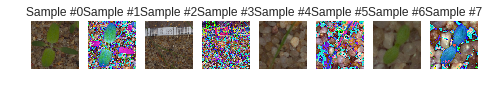

In [19]:
import matplotlib.pyplot as plt
imagesToShow = 4
mean_rgb = [0.485, 0.456, 0.406]
std_rgb =[0.229, 0.224, 0.225]


normalize_img = transforms.Normalize(mean=mean_rgb, std=std_rgb)


image_size = 224

normalized_train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img
    ])


normalized_train_set = DatasetLoader(train_data, normalized_train_data_transform)

normalized_train_loader = DataLoader(normalized_train_set, batch_size=1, shuffle=True, num_workers=0)



def flaotTensorToImage(img, mean=0, std=1):
  """convert a tensor to an image"""
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img*std+ mean)*255
  img = img.astype(np.uint8)    
  return img   


imageINdex = 0
for i, data in enumerate(normalized_train_loader, 0):
  
  images, labels = data            
  image=images[0]
  
  ax = plt.subplot(1, imagesToShow * 2, imageINdex + 1)
  ax.set_title('Sample #{}'.format(imageINdex))
  ax.axis('off')
  plt.imshow (flaotTensorToImage(image,mean_rgb,std_rgb))
  
  
  imageINdex += 1
  ax = plt.subplot(1, imagesToShow * 2, imageINdex + 1)
  ax.set_title('Sample #{}'.format(imageINdex))
  ax.axis('off')
  plt.imshow (flaotTensorToImage(image))
  imageINdex +=1
  

  if i==imagesToShow-1:
    break  
        